In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

sns.set()
pal = sns.color_palette()
DATA_DIR = '../data/'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Loading in data

In [2]:
station = pd.read_csv(DATA_DIR + 'raw/station.csv')
trip = pd.read_csv(DATA_DIR + 'raw/trip.csv')
weather = pd.read_csv(DATA_DIR + 'raw/weather.csv')

In [3]:
print('{0} observations and {1} variables.'.format(*station.shape))
station.head()

70 observations and 7 variables.


,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [4]:
print('{0} observations and {1} variables.'.format(*trip.shape))
trip.head()

669959 observations and 11 variables.


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [5]:
print('{0} observations and {1} variables.'.format(*weather.shape))
weather.head()

3665 observations and 24 variables.


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


# Data cleaning

The most pertinent dataset of the four is `trip`, which contains information about individual trips taken using the bikeshare services. First, we want to check for missing values:

In [6]:
trip.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

No missing values! A great sign.

Perhaps the most interesting column in `trip` is `duration`. We do some exploratory analysis:

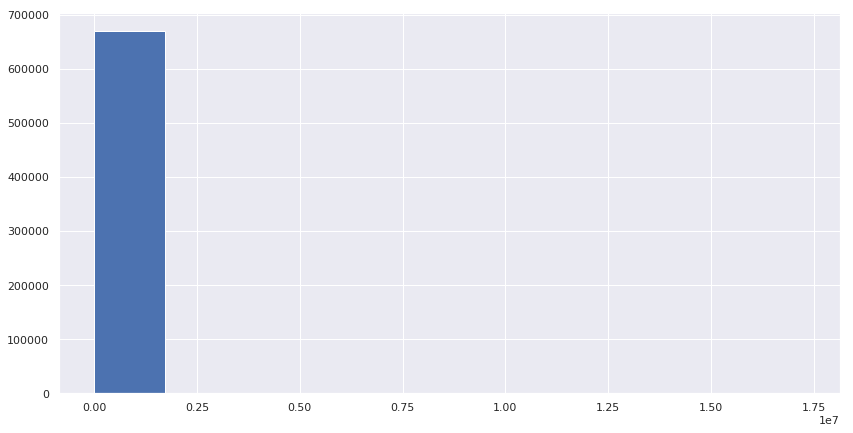

In [7]:
# Histogram of trip durations
plt.figure(figsize=(14, 7))
plt.hist(trip['duration']);

In [8]:
# Trip duration summary statistics
trip['duration'].describe()

count    6.699590e+05
mean     1.107950e+03
std      2.225544e+04
min      6.000000e+01
25%      3.440000e+02
50%      5.170000e+02
75%      7.550000e+02
max      1.727040e+07
Name: duration, dtype: float64

The histogram looks really weird! We observe that the 75th percentile has a value of 755 seconds (12.58 minutes), but the max value is 1,727,040 seconds (~20 days). Clearly this is an outlier; we attempt to remove the outlier trips with a trip length that is not representative of the population. Let's assume that a "representative" trip is under 1 hour; removing all trips above that threshold will remove about 3% of the data. (That's a lot in the world of removing outliers, but this is for preliminary data analysis; we can change this later in the modeling phase.)

In [9]:
# Check quantile of thresholding at 1 hour
trip['duration'].quantile(0.968) <= 60*60*1 <= trip['duration'].quantile(0.969)

True

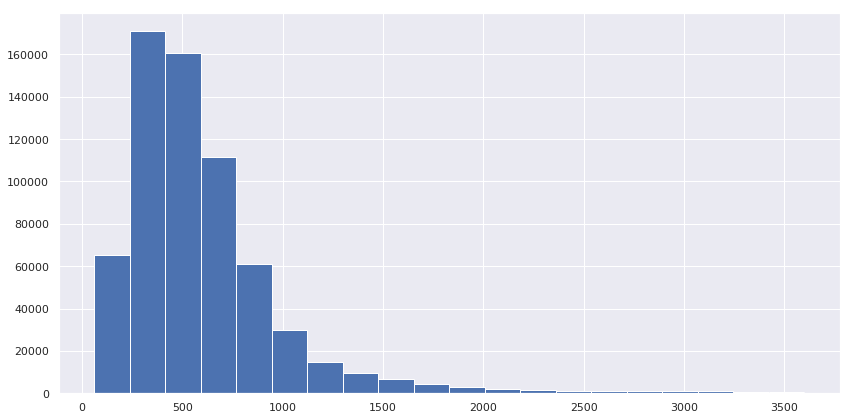

In [10]:
# Histogram if we limit data to 1 hour trips
plt.figure(figsize=(14, 7))
plt.hist(trip.loc[trip['duration'] <= 60*60*1, 'duration'], bins=20);

In [11]:
# Subset to data with duration 1 hour or less
trip = trip.loc[trip['duration'] <= 60*60*1]

# Create duration in minutes
trip['duration_mins'] = trip['duration'] / 60

# Change start_date and end_date from string to datetime objects
trip['start_date'] = pd.to_datetime(trip['start_date'], format='%m/%d/%Y %H:%M')
trip['end_date'] = pd.to_datetime(trip['end_date'], format='%m/%d/%Y %H:%M')

# Split up date and time into two separate variables
# Retain original as a renamed variable
trip = (
    trip
    .rename(columns={'start_date':'start_timestamp', 'end_date':'end_timestamp'})
    .assign(start_time=trip['start_date'].dt.time)
    .assign(end_time=trip['end_date'].dt.time)
    .assign(start_date=trip['start_date'].dt.date)
    .assign(end_date=trip['end_date'].dt.date)
)

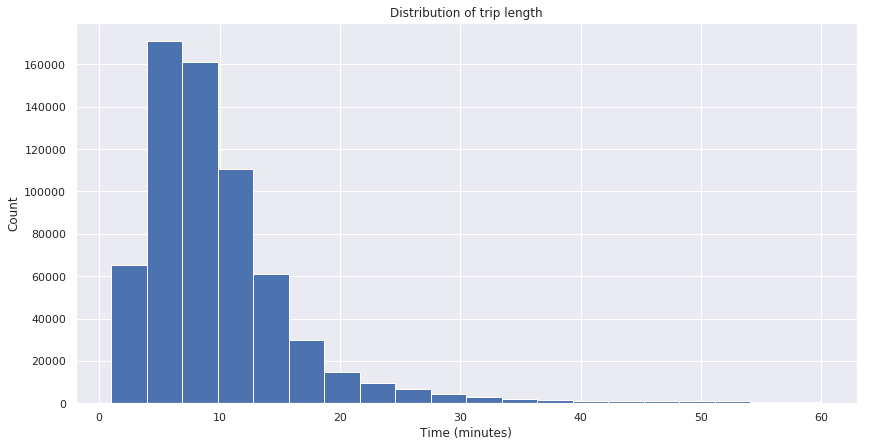

In [12]:
# Distribution of trip length, in minutes, for riders under 60 minutes
plt.figure(figsize=(14, 7))
plt.hist(trip['duration_mins'], bins=20)
plt.xlabel('Time (minutes)')
plt.ylabel('Count')
plt.title('Distribution of trip length')
plt.savefig('img/img_1_trip_length.png')

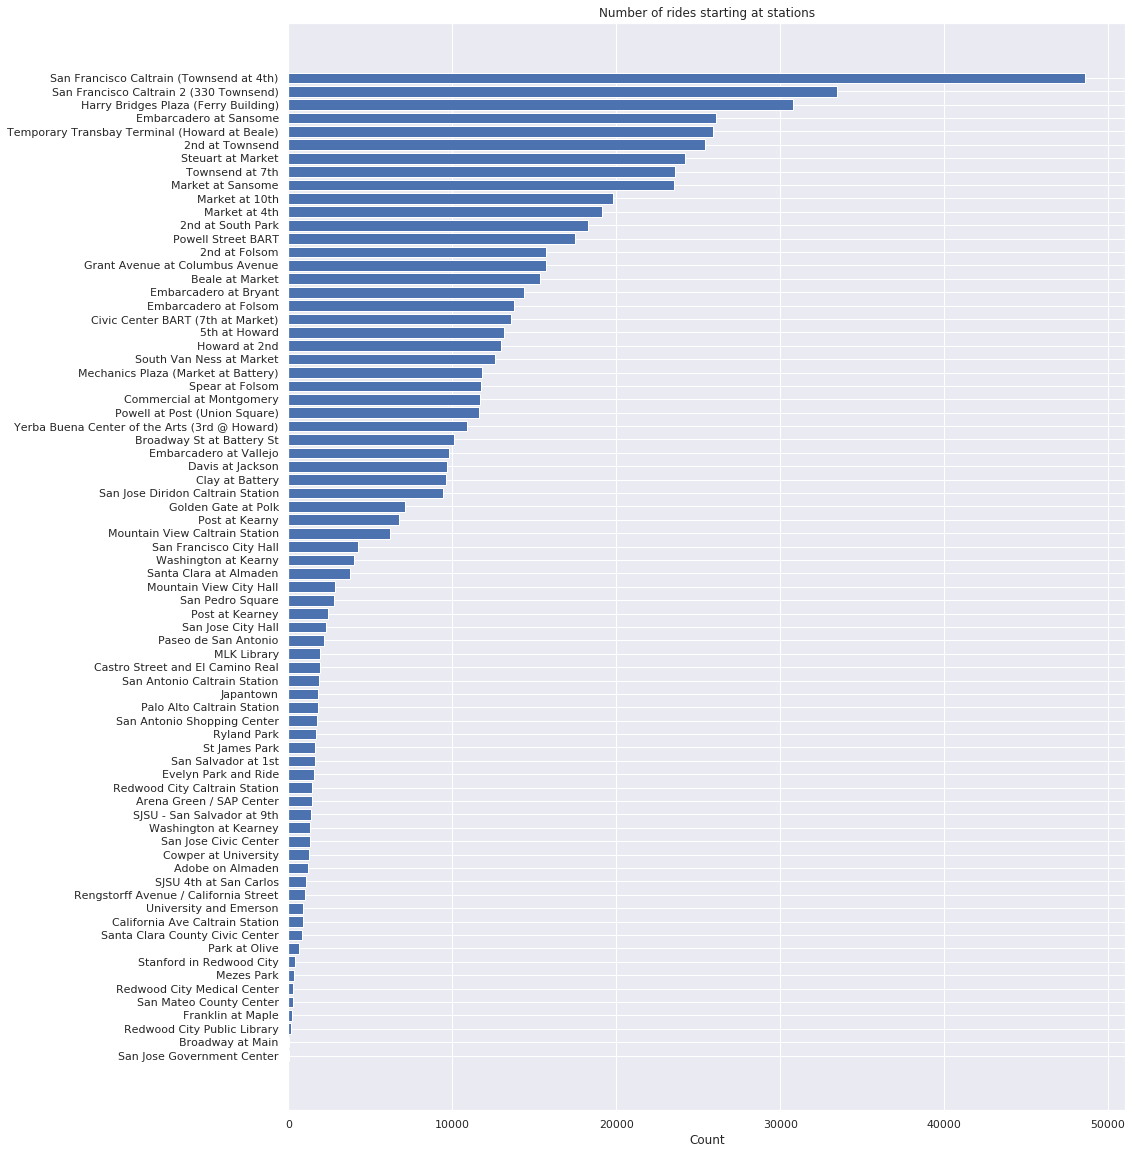

In [13]:
# Visualize ridership by station
fig, ax = plt.subplots(figsize=(15, 20))

start_stations = trip['start_station_name'].value_counts()
ax.barh(start_stations.index, start_stations.values)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title('Number of rides starting at stations')
fig.savefig('img/img_2_start_stations.png')

The vast majority of rides look like they occur in stations/monuments in San Francisco. We can confirm this by joining our `trip` data with `station` on both `start_station_name` and `end_station_name`.

In [14]:
# List of station cities
station['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [15]:
# Join once for start_station, and once for end_station
trip = (
    trip
    .merge(station[['name', 'city']], left_on='start_station_name', right_on='name')
    .rename(columns={'city':'start_station_city'})
    .drop(columns='name')
    .merge(station[['name', 'city']], left_on='end_station_name', right_on='name')
    .rename(columns={'city':'end_station_city'})
    .drop(columns='name')
)

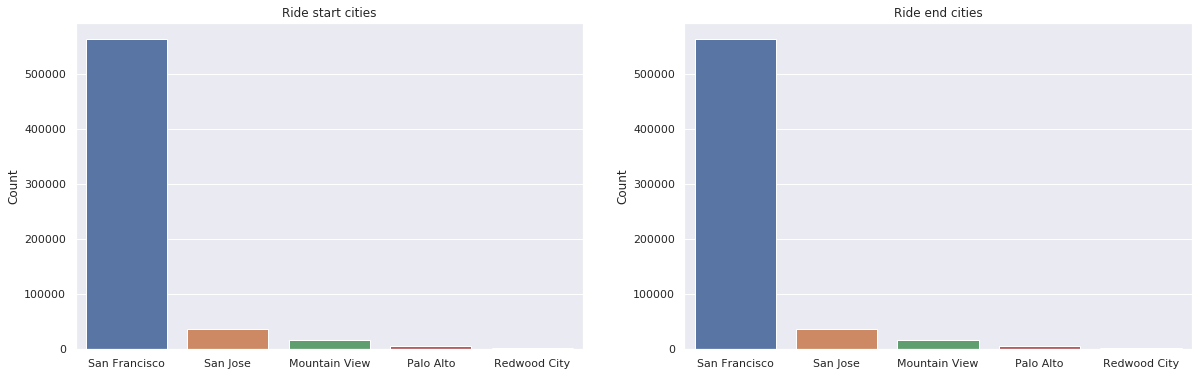

In [16]:
# Counts for start_station and end_station
start_station_cities = trip['start_station_city'].value_counts()
end_station_cities = trip['end_station_city'].value_counts()

# Visualize ridership by city
plt.figure(figsize=(20, 6))
plt.subplot(121)
sns.barplot(start_station_cities.index, start_station_cities.values)
plt.ylabel('Count')
plt.title('Ride start cities')

plt.subplot(122)
sns.barplot(end_station_cities.index, end_station_cities.values)
plt.ylabel('Count')
plt.title('Ride end cities')

plt.savefig('img/img_3_ride_start_end_city.png')

The number of rides in San Francisco far outnumber the rides in other cities! Let's focus our study on just SF; just to be sure, we first double-check that rides starting in SF always end in SF, and vice versa. (Nobody wants to bike all the way up the west side of the Bay, right..?)

In [17]:
# Starts in SF but does not end in SF
trip[(trip['start_station_city'] == 'San Francisco') & (trip['end_station_city'] != 'San Francisco')]

,id,duration,start_timestamp,start_station_name,start_station_id,end_timestamp,end_station_name,end_station_id,bike_id,subscription_type,zip_code,duration_mins,start_time,end_time,start_date,end_date,start_station_city,end_station_city
623805,151731,2525,2014-01-13 16:46:00,2nd at Townsend,61,2014-01-13 17:29:00,Redwood City Caltrain Station,22,422,Subscriber,94061,42.083333,16:46:00,17:29:00,2014-01-13,2014-01-13,San Francisco,Redwood City
623806,244143,3237,2014-04-10 17:35:00,Commercial at Montgomery,45,2014-04-10 18:29:00,Redwood City Caltrain Station,22,446,Customer,94061,53.950000,17:35:00,18:29:00,2014-04-10,2014-04-10,San Francisco,Redwood City


In [18]:
# Does not start in SF but ends in SF
trip[(trip['start_station_city'] != 'San Francisco') & (trip['end_station_city'] == 'San Francisco')]

,id,duration,start_timestamp,start_station_name,start_station_id,end_timestamp,end_station_name,end_station_id,bike_id,subscription_type,zip_code,duration_mins,start_time,end_time,start_date,end_date,start_station_city,end_station_city
34263,42493,236,2013-10-02 08:27:00,Redwood City Caltrain Station,22,2013-10-02 08:31:00,Civic Center BART (7th at Market),72,232,Subscriber,94105,3.933333,08:27:00,08:31:00,2013-10-02,2013-10-02,Redwood City,San Francisco
325223,385606,3553,2014-07-29 18:33:00,California Ave Caltrain Station,36,2014-07-29 19:32:00,San Francisco Caltrain (Townsend at 4th),70,705,Subscriber,94402,59.216667,18:33:00,19:32:00,2014-07-29,2014-07-29,Palo Alto,San Francisco


Turns out we're wrong; there are four such records. From the timestamps, it looks like the rides with IDs `151731`, `244143`, and `385606` had bikes taken on the Caltrain; ride `42493` looks like a clerical error - `duration_mins` for that ride is 3.93 minutes. We'll drop these four records and continue on with our data exploration.

In [19]:
# Remove all trips that do not start and end in SF
trip = (
    trip
    .loc[trip['start_station_city'] == 'San Francisco']
    .loc[~trip['id'].isin([151731, 244143, 385606, 42493])]
)

In [20]:
trip.head()

,id,duration,start_timestamp,start_station_name,start_station_id,end_timestamp,end_station_name,end_station_id,bike_id,subscription_type,zip_code,duration_mins,start_time,end_time,start_date,end_date,start_station_city,end_station_city
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,1.050000,14:13:00,14:14:00,2013-08-29,2013-08-29,San Francisco,San Francisco
1,4760,113,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,1.883333,17:01:00,17:03:00,2013-08-29,2013-08-29,San Francisco,San Francisco
2,5070,168,2013-08-29 21:43:00,South Van Ness at Market,66,2013-08-29 21:46:00,South Van Ness at Market,66,598,Subscriber,94115,2.800000,21:43:00,21:46:00,2013-08-29,2013-08-29,San Francisco,San Francisco
3,4584,262,2013-08-29 14:17:00,South Van Ness at Market,66,2013-08-29 14:21:00,South Van Ness at Market,66,587,Subscriber,94612,4.366667,14:17:00,14:21:00,2013-08-29,2013-08-29,San Francisco,San Francisco
4,4079,995,2013-08-29 09:35:00,South Van Ness at Market,66,2013-08-29 09:52:00,South Van Ness at Market,66,327,Subscriber,94102,16.583333,09:35:00,09:52:00,2013-08-29,2013-08-29,San Francisco,San Francisco


# EDA: `trip`

One of the first questions that comes to mind is: What does the ridership look like? If we want this at the day level, we have to choose either `start_date` or `end_date` as our variable of choice. We observe:

In [21]:
# Observations with different start_date and end_date
trip[trip['start_date'] != trip['end_date']]

,id,duration,start_timestamp,start_station_name,start_station_id,end_timestamp,end_station_name,end_station_id,bike_id,subscription_type,zip_code,duration_mins,start_time,end_time,start_date,end_date,start_station_city,end_station_city
512,608609,221,2015-01-17 23:58:00,Golden Gate at Polk,59,2015-01-18 00:01:00,South Van Ness at Market,66,478,Subscriber,94102,3.683333,23:58:00,00:01:00,2015-01-17,2015-01-18,San Francisco,San Francisco
727,239946,1025,2014-04-07 23:50:00,2nd at South Park,64,2014-04-08 00:07:00,South Van Ness at Market,66,287,Subscriber,94103,17.083333,23:50:00,00:07:00,2014-04-07,2014-04-08,San Francisco,San Francisco
1578,159880,1219,2014-01-20 23:41:00,Powell Street BART,39,2014-01-21 00:02:00,South Van Ness at Market,66,336,Customer,94121,20.316667,23:41:00,00:02:00,2014-01-20,2014-01-21,San Francisco,San Francisco
1579,159881,1202,2014-01-20 23:42:00,Powell Street BART,39,2014-01-21 00:02:00,South Van Ness at Market,66,384,Customer,94121,20.033333,23:42:00,00:02:00,2014-01-20,2014-01-21,San Francisco,San Francisco
1797,296750,470,2014-05-23 23:58:00,Powell Street BART,39,2014-05-24 00:06:00,South Van Ness at Market,66,435,Subscriber,94404,7.833333,23:58:00,00:06:00,2014-05-23,2014-05-24,San Francisco,San Francisco
1857,267392,371,2014-04-30 23:56:00,Powell Street BART,39,2014-05-01 00:02:00,South Van Ness at Market,66,398,Subscriber,94404,6.183333,23:56:00,00:02:00,2014-04-30,2014-05-01,San Francisco,San Francisco
5489,421799,624,2014-08-23 23:54:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2014-08-24 00:05:00,South Van Ness at Market,66,420,Subscriber,94103,10.400000,23:54:00,00:05:00,2014-08-23,2014-08-24,San Francisco,San Francisco
5802,825243,946,2015-06-27 23:50:00,Powell at Post (Union Square),71,2015-06-28 00:06:00,South Van Ness at Market,66,387,Customer,60613,15.766667,23:50:00,00:06:00,2015-06-27,2015-06-28,San Francisco,San Francisco
5803,825242,964,2015-06-27 23:50:00,Powell at Post (Union Square),71,2015-06-28 00:06:00,South Van Ness at Market,66,511,Customer,37087,16.066667,23:50:00,00:06:00,2015-06-27,2015-06-28,San Francisco,San Francisco
6618,6478,944,2013-08-30 23:51:00,Grant Avenue at Columbus Avenue,73,2013-08-31 00:07:00,South Van Ness at Market,66,448,Subscriber,94102,15.733333,23:51:00,00:07:00,2013-08-30,2013-08-31,San Francisco,San Francisco


In [22]:
len(trip)

564335

But it turns out, for visualization purposes this shouldn't be too big of an issue. A couple observations here and there (500 is pretty small in the scope of 560,000 observations) probably won't divert us too far from any trends.

In [23]:
# Group by start date and take the number of observations with each unique count date.
# Select 'id' column since it is a unique identifier for each ride
num_trips_by_date = (
    trip
    .groupby('start_date')
    .count()
    .loc[:, 'id']
)

num_trips_by_date.head()

start_date
2013-08-29    616
2013-08-30    545
2013-08-31    465
2013-09-01    510
2013-09-02    513
Name: id, dtype: int64

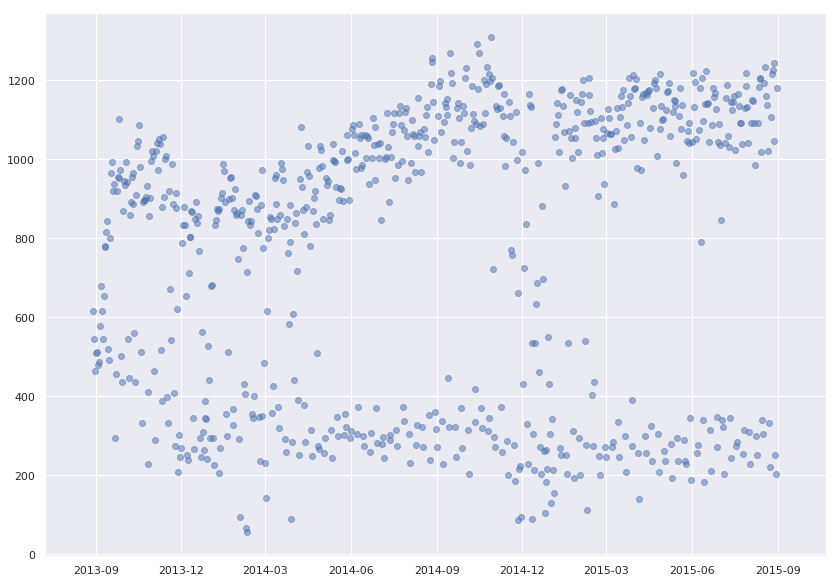

In [24]:
# Visualize ridership by day
plt.figure(figsize=(14, 10))
plt.scatter(num_trips_by_date.index, num_trips_by_date.values, alpha=0.5);

There are two very clear trends: one high, and one low. Even more interesting is that the trends seem to occur simultaneously, regardless of time of year. This means it's probably not related to the weather (cyclical by year). It could be a weekend/weekday discrepancy:

In [25]:
trip['start_date'].head()

0    2013-08-29
1    2013-08-29
2    2013-08-29
3    2013-08-29
4    2013-08-29
Name: start_date, dtype: object

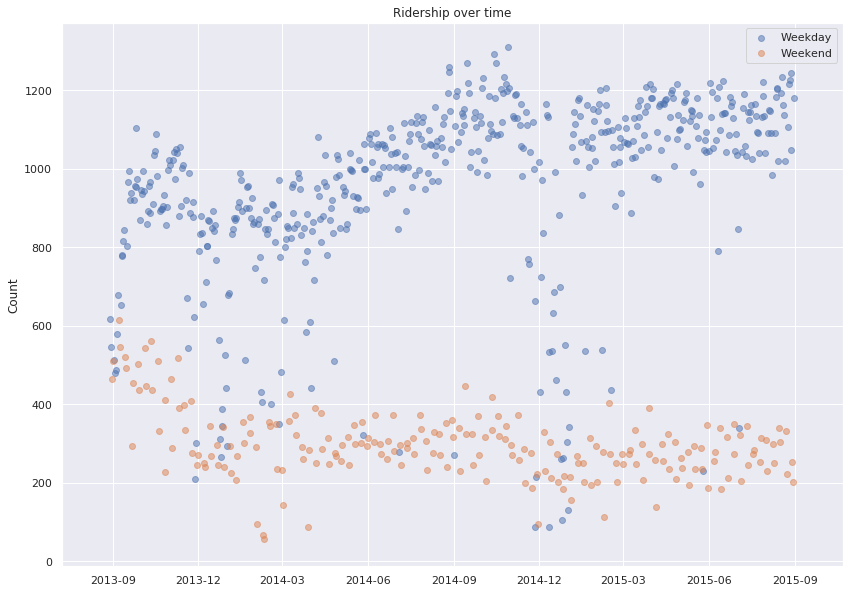

In [26]:
# New 'weekday' variable storing day of week as number from 0(Monday) to 6(Sunday)
trip = (
    trip
    .assign(weekday=trip['start_timestamp'].dt.weekday)
)

# Redo groupby with new 'weekday' column
num_trips_by_date = (
    trip
    .groupby(['start_date', 'weekday'])
    .count()
    .loc[:, 'id']
)

# Array of weekday values
weekday = num_trips_by_date.index.get_level_values('weekday')

plt.figure(figsize=(14, 10))
# Weekdays
plt.scatter(num_trips_by_date[weekday.isin(range(5))].index.get_level_values('start_date'), 
            num_trips_by_date[weekday.isin(range(5))].values, 
            color=pal[0], label='Weekday', alpha=0.5)
# Weekends
plt.scatter(num_trips_by_date[~weekday.isin(range(5))].index.get_level_values('start_date'), 
            num_trips_by_date[~weekday.isin(range(5))].values, 
            color=pal[1], label='Weekend', alpha=0.5)
plt.legend()

plt.ylabel('Count')
plt.title('Ridership over time')
plt.savefig('img/img_4_ridership_over_time.png')

That explains a lot of things! There seem to be sporadic points of low ridership each year from December to March; perhaps this is attributable to weather.

Another way to visualize this data is using a bar chart; we lose out on granularity, but we do tend to be better at analyzing differences when using bars.

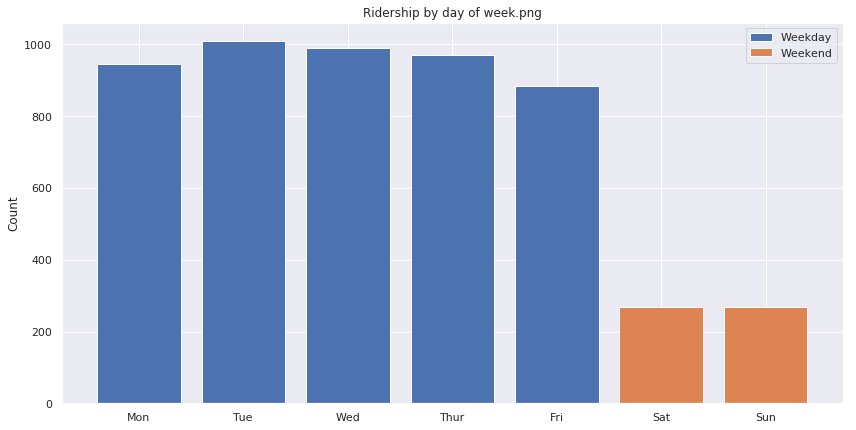

In [27]:
plt.figure(figsize=(14, 7))
# Weekdays
plt.bar(['Mon', 'Tue', 'Wed', 'Thur', 'Fri'],
        num_trips_by_date.groupby('weekday').mean()[:5], 
        color=pal[0], label='Weekday')
# Weekends
plt.bar(['Sat', 'Sun'],
        num_trips_by_date.groupby('weekday').mean()[6:], 
        color=pal[1], label='Weekend')
plt.legend()

plt.ylabel('Count')
plt.title('Ridership by day of week.png')
plt.savefig('img/img_5_ridership_by_day_of_week.png')

Why might weekday ridership be so much higher than weekend ridership? One guess we can make is that commuters use bikes to travel to/from work. To confirm this, we can group by each hour and see ridership over the course of the day.

In [28]:
trip = trip.assign(start_hour=trip['start_timestamp'].dt.hour)

# Group by hour
num_trips_by_hour = (
    trip
    .groupby('start_hour')
    .count()
    .loc[:, 'id']
)

num_trips_by_hour.head()

start_hour
0    1650
1     747
2     498
3     252
4     952
Name: id, dtype: int64

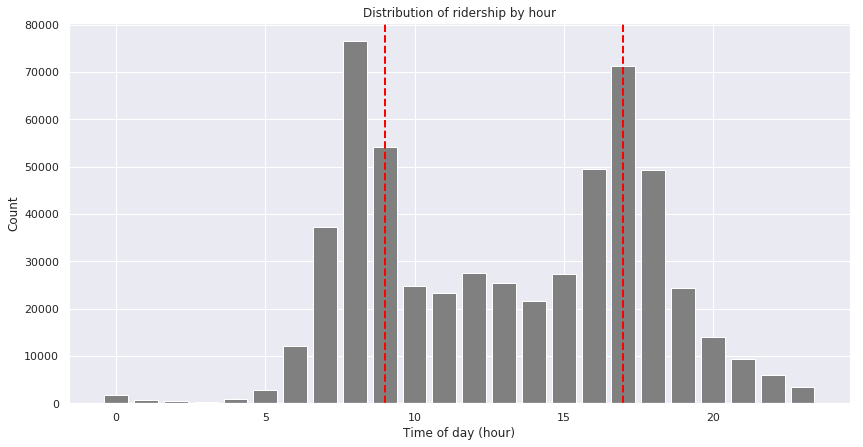

In [29]:
plt.figure(figsize=(14, 7))
# Plot ridership by hour
plt.bar(num_trips_by_hour.index, num_trips_by_hour.values, color='gray')
# Vertical lines at 9am and 5pm
plt.axvline(9, color='red', linestyle='dashed', linewidth=2)
plt.axvline(17, color='red', linestyle='dashed', linewidth=2)

plt.xlabel('Time of day (hour)')
plt.ylabel('Count')
plt.title('Distribution of ridership by hour')
plt.savefig('img/img_6_ridership_by_hour.png')

Fascinating. The Ford GoBike program seems to be very popular amongst commuters! One last variable of interest remains in the `trip` dataset: `subscription_type`. 

In [30]:
# All types of subscriptions
trip['subscription_type'].unique()

array(['Subscriber', 'Customer'], dtype=object)

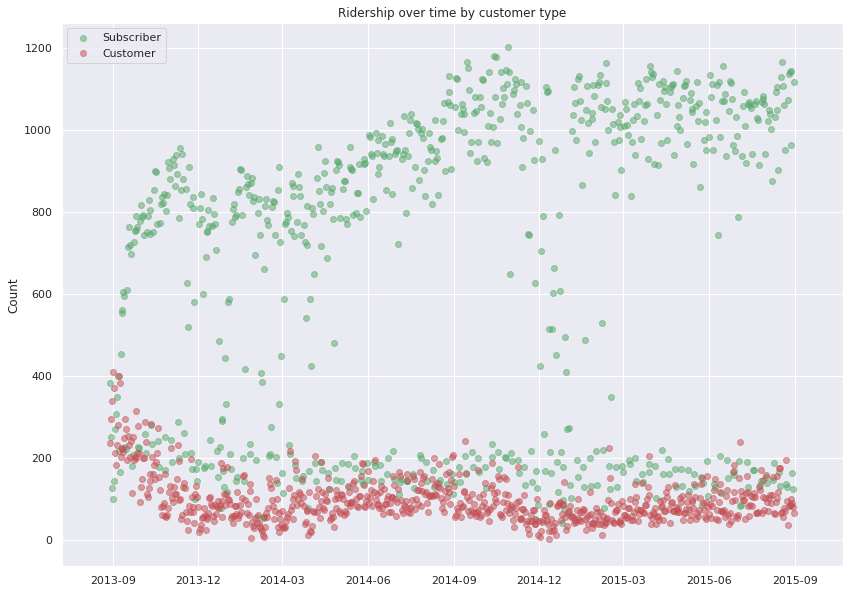

In [31]:
# Redo num_trips_by_day with additional 'subscription_type' column
num_trips_by_date_by_subscription = (
    trip
    .groupby(['start_date', 'weekday', 'subscription_type'])
    .count()
    .loc[:, 'id']
)

# Array of weekday values, subscription type values
weekday = num_trips_by_date_by_subscription.index.get_level_values('weekday')
subscription_type = num_trips_by_date_by_subscription.index.get_level_values('subscription_type')

plt.figure(figsize=(14, 10))
# Subscribers
plt.scatter(num_trips_by_date_by_subscription[subscription_type == 'Subscriber'].index.get_level_values('start_date'), 
            num_trips_by_date_by_subscription[subscription_type == 'Subscriber'].values, 
            color=pal[2], label='Subscriber', alpha=0.5)
# Customers
plt.scatter(num_trips_by_date_by_subscription[subscription_type == 'Customer'].index.get_level_values('start_date'), 
            num_trips_by_date_by_subscription[subscription_type == 'Customer'].values, 
            color=pal[3], label='Customer', alpha=0.5)
plt.legend()

plt.ylabel('Count')
plt.title('Ridership over time by customer type')
plt.savefig('img/img_7_ridership_over_time_by_customer.png')

Again, those green "Subscriber" points near the red "Customer" points are probably the weekend days, since subscribed commuters don't go to work on the weekends. We observe:

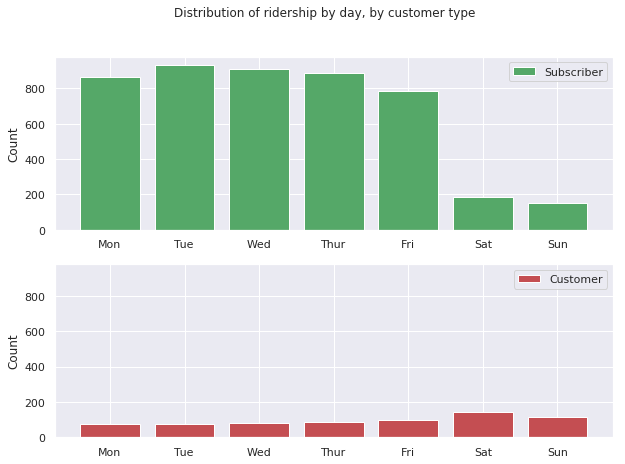

In [32]:
num_trips_by_day_by_subscription = num_trips_by_date_by_subscription.groupby(['weekday', 'subscription_type']).mean()
subscription_type_by_day = num_trips_by_day_by_subscription.index.get_level_values('subscription_type')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
# Weekdays
ax1.bar(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'],
        num_trips_by_day_by_subscription[subscription_type_by_day == 'Subscriber'], 
        color=pal[2], label='Subscriber')
ax1.legend()
ax1.set_ylabel('Count')
# Weekends
ax2.bar(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'],
        num_trips_by_day_by_subscription[subscription_type_by_day == 'Customer'], 
        color=pal[3], label='Customer')
ax2.set_ylim(ax1.get_ylim())
ax2.legend()
ax2.set_ylabel('Count')

fig.suptitle('Distribution of ridership by day, by customer type')
fig.savefig('img/img_8_ridership_by_day_by_customer_type.png')

Indeed, quite the stark difference. That's really interesting to observe! One thing that stands out is that Subscribers tend to ride more on the weekends than their Customer counterparts. This is visible on both the bar plot (where Saturday and Sunday have higher mean values for Subscribers than for Customers), as well as on the scatterplot (generally, the Subscribers' weekend data points have a higher rider count than the Customers, though we are comparing apples (Subscribers/Weekend) to both apples and oranges (Subscribers/Weekend and Subscribers/Weekday)). Certainly, being a subscriber would incentivize individuals to take advantage of their subscription by riding on the weekends as well. 

# EDA: `weather`

We now look at the weather dataset to identify potential features we could use to predict ridership. We expect that weather generally is a good indicator of ridership; bike rides are suboptimal in rainy weather, for example.

In [33]:
print('{0} observations and {1} variables.'.format(*weather.shape))
weather.head()

3665 observations and 24 variables.


,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


As in the last dataset, we replace the date with a datetime, then we check for missing values.

In [34]:
# Replace date with a datetime object
weather['date'] = pd.to_datetime(weather['date'], format='%m/%d/%Y')

In [35]:
# Check for missing values
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

Lots of missing values in this one. Let's take a closer look at the data to see how we might clean the dataset:

In [36]:
weather['zip_code'].unique()

array([94107, 94063, 94301, 94041, 95113])

Only five zip codes:
- 94107: Dogpatch (SF)
- 94063: Redwood City
- 94301: Palo Alto
- 94041: Mountain View
- 95113: Downtown San Jose

Since we only want to know San Francisco, we can remove the other four cities.

In [37]:
weather = weather.loc[weather['zip_code'] == 94107]

print(weather.shape)
weather.isnull().sum()

(733, 24)


date                                0
max_temperature_f                   0
mean_temperature_f                  0
min_temperature_f                   0
max_dew_point_f                     0
mean_dew_point_f                    0
min_dew_point_f                     0
max_humidity                        0
mean_humidity                       0
min_humidity                        0
max_sea_level_pressure_inches       0
mean_sea_level_pressure_inches      0
min_sea_level_pressure_inches       0
max_visibility_miles                0
mean_visibility_miles               0
min_visibility_miles                0
max_wind_Speed_mph                  0
mean_wind_speed_mph                 0
max_gust_speed_mph                 13
precipitation_inches                0
cloud_cover                         0
events                            574
wind_dir_degrees                    0
zip_code                            0
dtype: int64

Looks like this subset of `weather` is a lot cleaner, which is good news. Let's look at `max_gust_speed_mph` first:

In [38]:
weather['max_gust_speed_mph'].describe()

count    720.000000
mean      24.197222
std        7.961485
min        6.000000
25%       20.000000
50%       24.000000
75%       28.000000
max       93.000000
Name: max_gust_speed_mph, dtype: float64

Doesn't look like any particular problem; we might just have missing data points. We can use a highly correlated feature to impute the values.

In [39]:
weather.corr()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,cloud_cover,wind_dir_degrees,zip_code
max_temperature_f,1.000000,0.907018,0.599123,0.585565,0.485000,0.372426,-0.167614,-0.367892,-0.425437,-0.392300,...,-0.304290,0.065450,0.259442,0.319660,0.040472,0.043484,0.049461,-0.294906,0.352683,NaN
mean_temperature_f,0.907018,1.000000,0.878855,0.744692,0.709754,0.631826,-0.119592,-0.146660,-0.140145,-0.548537,...,-0.444962,0.084117,0.242662,0.267681,0.200515,0.292530,0.172073,0.005758,0.344763,NaN
min_temperature_f,0.599123,0.878855,1.000000,0.763253,0.810161,0.787317,-0.035102,0.141349,0.218189,-0.602953,...,-0.504217,0.090202,0.169074,0.145757,0.334721,0.505902,0.271586,0.351110,0.262218,NaN
max_dew_point_f,0.585565,0.744692,0.763253,1.000000,0.937803,0.835197,0.415598,0.433438,0.368626,-0.458493,...,-0.391414,0.021887,-0.061866,-0.107687,0.125441,0.208353,0.125267,0.305876,0.340164,NaN
mean_dew_point_f,0.485000,0.709754,0.810161,0.937803,1.000000,0.958505,0.440609,0.548634,0.517298,-0.514441,...,-0.430538,0.021682,-0.055872,-0.090789,0.155963,0.289453,0.141173,0.418627,0.338566,NaN
min_dew_point_f,0.372426,0.631826,0.787317,0.835197,0.958505,1.000000,0.403131,0.591045,0.599512,-0.515010,...,-0.424707,0.027232,-0.014430,-0.052347,0.171579,0.343769,0.145318,0.468698,0.297423,NaN
max_humidity,-0.167614,-0.119592,-0.035102,0.415598,0.440609,0.403131,1.000000,0.812889,0.567535,-0.035698,...,-0.052007,-0.074736,-0.410555,-0.469724,-0.051900,-0.080404,-0.010964,0.311396,0.148812,NaN
mean_humidity,-0.367892,-0.146660,0.141349,0.433438,0.548634,0.591045,0.812889,1.000000,0.940047,-0.100036,...,-0.103147,-0.071264,-0.423848,-0.500710,0.032700,0.101429,0.033319,0.607536,0.046938,NaN
min_humidity,-0.425437,-0.140145,0.218189,0.368626,0.517298,0.599512,0.567535,0.940047,1.000000,-0.118393,...,-0.113625,-0.058087,-0.361260,-0.435115,0.079320,0.191904,0.055003,0.677250,-0.019325,NaN
max_sea_level_pressure_inches,-0.392300,-0.548537,-0.602953,-0.458493,-0.514441,-0.515010,-0.035698,-0.100036,-0.118393,1.000000,...,0.932755,-0.091711,-0.113153,-0.061578,-0.428145,-0.488336,-0.366643,-0.192339,-0.256942,NaN


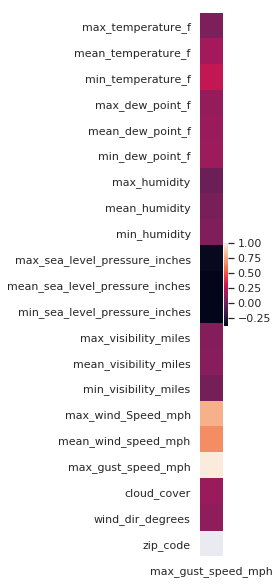

In [40]:
plt.figure(figsize=(0.5, 10))
sns.heatmap(weather.corr()[['max_gust_speed_mph']]);

The heatmap indicates which variables are highly correlated with `max_gust_speed_mph`; the lighter the color, the higher the correlation. It shows that `max_wind_Speed_mph` is the most correlated (from the correlation matrix above it, we can see that the exact correlation value is 0.788848). It turns out that `max_wind_Speed_mph` is recorded to the nearest integer, which means that we can impute missing `max_gust_speed_mph` values with the median `max_gust_speed_mph` of the corresponding `max_wind_Speed_mph` (verbose, but it makes more sense in code form).

In [41]:
weather['max_wind_Speed_mph'].value_counts()

21.0    88
18.0    87
20.0    84
22.0    61
17.0    54
15.0    40
16.0    34
13.0    29
23.0    28
14.0    26
12.0    25
24.0    24
8.0     19
25.0    18
9.0     18
10.0    13
26.0    12
28.0    12
29.0    12
7.0     11
30.0     8
31.0     6
32.0     5
36.0     5
35.0     4
33.0     2
5.0      2
6.0      2
43.0     1
39.0     1
41.0     1
38.0     1
Name: max_wind_Speed_mph, dtype: int64

In [42]:
MEDIAN_MAXGUST = weather['max_gust_speed_mph'].median()

# For the rows that have missing max gust:
weather.loc[weather['max_gust_speed_mph'].isnull(), 'max_gust_speed_mph'] = (
    weather
    .loc[:, ['max_wind_Speed_mph', 'max_gust_speed_mph']]    # Select columns of interest
    .groupby('max_wind_Speed_mph')                           # Group by max wind speed
    # fill each max wind speed's missing max gust speed values with the median of its max gust speed
    .apply(lambda x: x.fillna(x.median() if x.median().isnull().values[1] is False else MEDIAN_MAXGUST))
)

Now we look at the `events` column to see how we can deal with the missing values:

In [43]:
weather['events'].unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

A couple things to note:
- `rain` and `Rain` should be the same
- `nan` values can be replaced with `Normal` to indicate no particular weather anomalies occured on that day
- `events` is a categorical variable, so we will need to create dummy variables

In [44]:
weather.loc[weather['events'] == 'rain', 'events'] = 'Rain'
weather['events'].fillna('Normal')
events_dummies = pd.get_dummies(weather['events'], drop_first=True)
weather = pd.concat([weather, events_dummies], axis=1)
weather = weather.drop(columns='events')

Now that we've taken care of the missing values, there are a few more variables that have issues:
- `zip_code` doesn't contribute to our model and should be removed
- `precipitation_inches` has a string dtype because of some of its values; that needs to get changed to a numeric dtype

In [45]:
weather = weather.drop(columns='zip_code')

In [46]:
weather['precipitation_inches'].dtype

dtype('O')

In [47]:
weather['precipitation_inches'].unique()

array(['0', '0.23', 'T', '0.01', '0.28', '0.63', '0.29', '0.06', '0.85',
       '0.09', '0.64', '0.42', '0.35', '0.43', '0.22', '0.74', '0.03',
       '0.02', '0.1', '0.26', '0.15', '0.87', '0.57', '0.69', '0.32',
       '0.11', '0.2', '0.66', '0.08', '1.18', '1.43', '3.12', '0.48',
       '0.19', '1.09', '0.65', '0.13', '0.25', '0.91', '0.99', '0.07',
       '0.05', '0.52', '0.14', '0.18'], dtype=object)

Looks like the 'T' value is holding up the entire column! Let's see if it's prevalent (which could suggest it stands for something).

In [48]:
weather['precipitation_inches'].value_counts()

0       586
T        70
0.01     16
0.02      5
0.23      3
0.32      3
0.11      3
0.03      2
0.08      2
0.26      2
0.09      2
0.1       2
0.43      2
0.63      2
0.15      2
0.57      2
0.85      1
0.19      1
0.48      1
0.06      1
0.18      1
3.12      1
0.66      1
0.91      1
0.28      1
0.25      1
0.69      1
1.09      1
0.07      1
0.2       1
1.18      1
0.65      1
0.52      1
0.99      1
0.74      1
0.87      1
1.43      1
0.05      1
0.13      1
0.42      1
0.64      1
0.22      1
0.14      1
0.29      1
0.35      1
Name: precipitation_inches, dtype: int64

Actually, it's quite prevalent. Perhaps it's an indication that it did rain (T = True); in that case, we'll want to impute it with the median precipitation in inches on days that it does rain.

In [49]:
MEDIAN_PRECIP_RAINY_DAYS = weather.loc[~weather['precipitation_inches'].isin(['T', '0']), 'precipitation_inches'].median()
MEDIAN_PRECIP_RAINY_DAYS

0.15

In [50]:
weather.loc[weather['precipitation_inches'] == 'T', 'precipitation_inches'] = MEDIAN_PRECIP_RAINY_DAYS
weather['precipitation_inches'] = weather['precipitation_inches'].astype(np.float64)

# Saving our cleaned data

Our goal is to predict how many rides there will be on a given day. It would be great if we could have access to more data... but since we don't, we'll see if we can predict 2014-2015 ridership using 2013-2014 ridership data. First, we'll want to save our data that we spent so much effort cleaning! We format `num_trips_by_date` (which will form our `y_train` and `y_test`), and save as CSV.

In [51]:
num_trips_by_date.reset_index(level=1, drop=True).to_frame().rename(columns={'id': 'num_trips'}).head()

,num_trips
start_date,
2013-08-29,616
2013-08-30,545
2013-08-31,465
2013-09-01,510
2013-09-02,513


In [52]:
(
    num_trips_by_date
    .reset_index(level=1, drop=True)
    .to_frame()
    .rename(index={'start_date': 'date'}, columns={'id': 'num_trips'})
    .to_csv(DATA_DIR + 'clean/num_trips_by_date.csv')
)

Next, we save our cleaned weather data, which will contribute to our features (i.e. `X_train` and `X_test`).

In [53]:
(
    weather
    .set_index('date')
    .to_csv(DATA_DIR + 'clean/weather_clean.csv')
)